In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [50]:
df = pd.read_csv('data_for_churn_analysis.csv')

In [3]:
df.shape

(104143, 18)

In [4]:
df.head()

,device,first_payment_amount,age,city,number_of_cards,payments_initiated,payments_failed,payments_completed,payments_completed_amount_first_7days,reward_purchase_count_first_7days,coins_redeemed_first_7days,is_referral,visits_feature_1,visits_feature_2,given_permission_1,given_permission_2,user_id,is_churned
0,samsung,0,20.0,Ahmedabad,2.0,1.0,0.0,1.0,0.0,NaN,0.0,False,3.0,0.0,1,0,269438,0
1,xiaomi,0,20.0,Surat,1.0,1.0,0.0,1.0,0.0,NaN,0.0,True,0.0,0.0,1,0,139521,0
2,xiaomi,0,20.0,Kullu,1.0,2.0,1.0,1.0,0.0,0.0,0.0,True,0.0,0.0,0,1,307352,0
3,oneplus,0,20.0,Mumbai,2.0,4.0,1.0,2.0,322.0,2.0,20.0,False,0.0,0.0,1,1,456424,0
4,apple,0,20.0,Pune,2.0,1.0,0.0,1.0,0.0,0.0,0.0,False,0.0,1.0,1,1,398779,0


In [5]:
df['is_churned'].value_counts(normalize=True)

is_churned
0    0.713192
1    0.286808
Name: proportion, dtype: float64

In [6]:
df.columns

Index(['device', 'first_payment_amount', 'age', 'city', 'number_of_cards',
       'payments_initiated', 'payments_failed', 'payments_completed',
       'payments_completed_amount_first_7days',
       'reward_purchase_count_first_7days', 'coins_redeemed_first_7days',
       'is_referral', 'visits_feature_1', 'visits_feature_2',
       'given_permission_1', 'given_permission_2', 'user_id', 'is_churned'],
      dtype='object')

## **Deep neural networks (DNNs) for propensity score matching**

1. **Impact of Referrals on Customer Acquisition and Retention**:
   - Research Question: Do customers acquired through referrals (`is_referral`) exhibit different behaviors and retention rates compared to non-referred customers?
   - Treatment: Customer acquisition through referrals
   - Outcome: Customer behavior (e.g., `payments_initiated`, `payments_completed`, `visits_feature_1`, `visits_feature_2`) and churn (`is_churned`)
   - Potential Confounders: `device`, `age`, `city`, `number_of_cards`, `payments_failed`, `payments_completed_amount_first_7days`, `reward_purchase_count_first_7days`, `coins_redeemed_first_7days`, `given_permission_1`, `given_permission_2`

In [51]:
# Packages

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

### **Preprocessing**

In [52]:
# Preprocessing
obj_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in obj_cols:
    df[col] = le.fit_transform(df[col])

df['is_referral'] = df['is_referral'].astype('int')


In [53]:
# Dealing with missing values
missing_cols = df.columns[df.isna().any()].tolist()
for col in missing_cols:
    df[col] = df[col].fillna(df[col].mean())

### **Data Split**

In [54]:
confounders = [
    'device',
    'age',
    'city',
    'number_of_cards',
    'payments_failed',
    'payments_completed_amount_first_7days',
    'reward_purchase_count_first_7days',
    'coins_redeemed_first_7days',
    'given_permission_1',
    'given_permission_2',
    'is_referral' # treatment
]

# 
y = df['is_churned']
X = df[confounders]

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [56]:
# converting to pytorch tensors
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.long)
X_val = torch.tensor(X_val.to_numpy(), dtype=torch.float32) # 
y_val = torch.tensor(y_val.to_numpy(), dtype=torch.long)

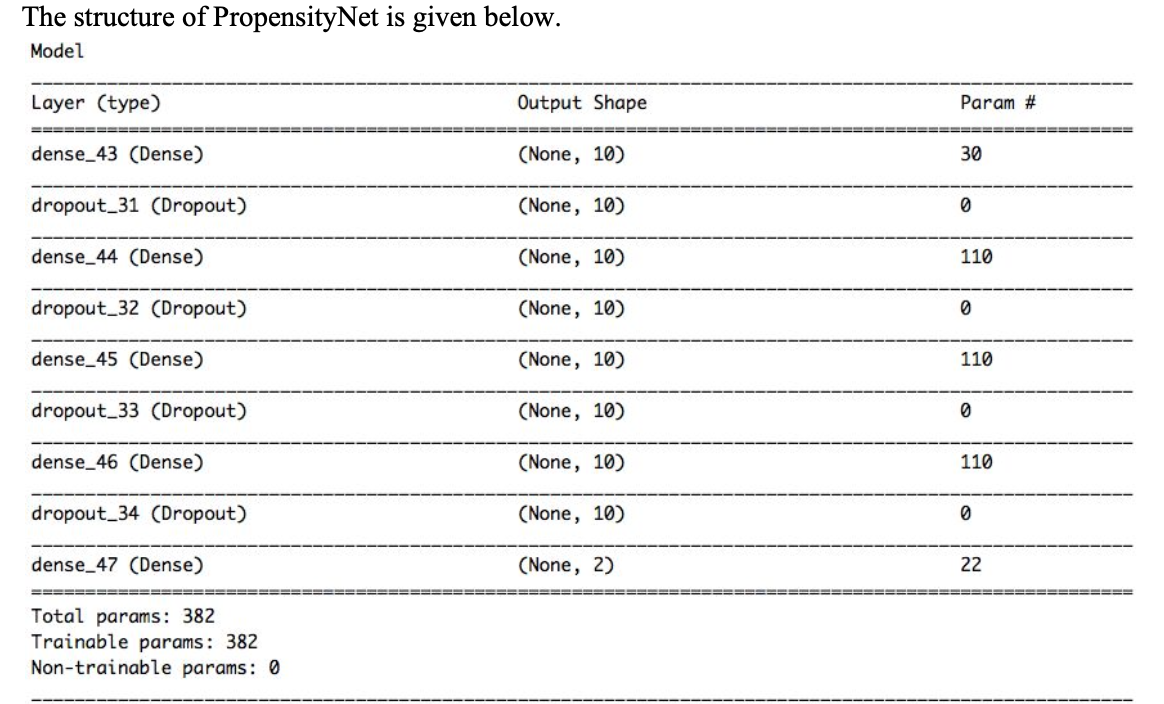

In [32]:
X_train.shape

torch.Size([83314, 11])

In [40]:
num_inputs = X_train.shape[1] # 4
num_outputs = len(torch.unique(y_train)) 

In [43]:
num_inputs

11

In [77]:
model = nn.Sequential(
        nn.Linear(11, 30),
        nn.ReLU(),
        nn.Linear(30, 30),
        nn.ReLU(),
        nn.Linear(30, 30),
        nn.ReLU(),
        nn.Linear(30, 10),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(10, 1),
        nn.Sigmoid()
    )

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)


# Dataloaders

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=220, shuffle=True)


val_dataset = TensorDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=220, shuffle=True)


In [79]:
# Training loop
for epoch in range(20):
    for inputs, labels in train_dataloader:

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels.float())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

    print("epoch: {0} training loss {1}".format(epoch, loss))

# Evaluation loop
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in val_dataloader:

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


    print(f'Accuracy: {100 * correct / total:.2f}%')

epoch: 0 training loss 0.5397917628288269


epoch: 1 training loss 0.5244520306587219
epoch: 2 training loss 0.49885618686676025
epoch: 3 training loss 0.5080711841583252
epoch: 4 training loss 0.5039994120597839
epoch: 5 training loss 0.5347684025764465
epoch: 6 training loss 0.5481727123260498
epoch: 7 training loss 0.524367094039917
epoch: 8 training loss 0.5591070652008057
epoch: 9 training loss 0.5593691468238831
epoch: 10 training loss 0.5351234674453735
epoch: 11 training loss 0.5244241952896118
epoch: 12 training loss 0.5113491415977478
epoch: 13 training loss 0.45493119955062866
epoch: 14 training loss 0.5097987055778503
epoch: 15 training loss 0.5466006398200989
epoch: 16 training loss 0.5056902170181274
epoch: 17 training loss 0.5277634859085083
epoch: 18 training loss 0.5292220711708069
epoch: 19 training loss 0.4809565246105194
Accuracy: 71.51%


In [47]:
inputs

tensor([[ 48.,  24., 678.,  ...,   1.,   1.,   0.],
        [ 50.,  33.,   8.,  ...,   1.,   1.,   0.],
        [ 51.,  40.,  87.,  ...,   1.,   1.,   1.],
        ...,
        [ 69.,  26., 624.,  ...,   1.,   1.,   1.],
        [ 54.,  33., 430.,  ...,   1.,   1.,   1.],
        [ 69.,  25., 751.,  ...,   1.,   0.,   0.]], dtype=torch.float64)

In [48]:
model(inputs)

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float